In [1]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from helpers import *

data_folder = 'DATA/'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lucil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
# load data
movie_data = pd.read_csv(data_folder + 'movie_data.csv')
character_data = pd.read_csv(data_folder + 'characters_data.csv')
main_characters = pd.read_csv(data_folder + "main_characters_20_per_year")

C:\Users\lucil\AppData\Local\Temp\ipykernel_24396\3248464955.py:3: DtypeWarning: Columns (2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  character_data = pd.read_csv(data_folder + 'characters_data.csv')


## Normalising revenue per year --> TO ADD IN M3
We retrieved the box-office revenues in US dollars. However, the rate of the dollar fluctuates throughout time and we can thus not compare a revenue from a movie in 1980 to one of a movie in 2022. To solve this problem, we decided to normalise the movie revenues per year to get an index that would indicate how popular each movie was per year. Another problem arise when doing so: when a movie was so famous that it got record box-office this year (e.g. Avatar, Star Wars, ...), even the second or third movie at the box-office will have a really low popularity index which does not represent reality very well. What we did was thus to do an average of the first 3 movies of the box-office as our maximum value. This should mitigate this effect.
Additionally, a lot of movies do not have their box-office revenue statistics, so we will do this normalisation only for the years that have enough data and drop the other years.

In [3]:
movie_data_per_year = movie_data.groupby('release_date').count()
fraction_box_office_per_year = movie_data_per_year['box_office_revenue']*100/movie_data_per_year['IMDB_ID']
print((fraction_box_office_per_year > 10).sum()) #112 years in total, 56 > 10%

59


In [4]:
def get_pop_index(data):
    data_per_year = data.groupby('release_date').count()
    fraction_box_office_per_year = data_per_year['box_office_revenue']*100/data_per_year['IMDB_ID']
    box_office_years = fraction_box_office_per_year[fraction_box_office_per_year>10].index

    top_three_per_year = data.groupby('release_date')['box_office_revenue'].nlargest(3)
    max_per_year = top_three_per_year.groupby('release_date').mean()
    pop_index = []
    for i in range(data.shape[0]):
        year = data['release_date'][i]
        if year in box_office_years:
            pop_index.append(data['box_office_revenue'][i]/max_per_year[year])
        else: pop_index.append(None)
    return pop_index

In [5]:
movie_data['popularity'] = get_pop_index(movie_data)

In [6]:
movie_data

,IMDB_ID,wikipedia_ID,freebase_ID,runtime,name,release_date,genre,plot_summary,box_office_revenue,popularity
0,tt0228333,975900.0,/m/03vyhn,98.0,Ghosts of Mars,2001.0,"['Action', 'Science Fiction', 'Adventure', 'Th...","Set in the second half of the 22nd century, th...",14010832.0,0.031534
1,tt0245916,3196793.0,/m/08yl5d,95.0,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,"['Biography', 'Mystery', 'Drama']",NaN,NaN,NaN
2,tt0002894,13696889.0,/m/03cfc81,35.0,The Gangsters,1913.0,"['Comedy', 'Indie']",NaN,NaN,NaN
3,tt0029852,10408933.0,/m/02qc0j7,106.0,Alexander's Ragtime Band,1938.0,"['Musical', 'Comedy']",NaN,3600000.0,NaN
4,tt0021335,175026.0,/m/017n1p,86.0,Sarah and Son,1930.0,['Drama'],NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
53631,tt9913288,NaN,NaN,NaN,Letters,2020.0,[],"[""Charlie Porter is an ordinary man. He leads ...",NaN,NaN
53632,tt9914522,NaN,NaN,NaN,The Holden Family Plan,2019.0,[],"[""When Mackenzie Holden's sister and brother i...",NaN,NaN
53633,tt9914582,NaN,NaN,NaN,However Long,2019.0,[],['Documentary following four women with incura...,NaN,NaN
53634,tt9914642,NaN,NaN,NaN,Albatross,2017.0,[],"[""ALBATROSS is a powerful visual journey into ...",NaN,NaN


# Clustering
The idea is to create a dataframe for each movie with the characteristics extracted from the data that could make them more stereotypical, namely:
- proportion of women in the movie
- female/male ratio of main character
- difference between age of men and of women (difference of means?)
- persona (top verb, adjective and name attributed to women)

The clustering algorithm should thus group movies together that have similar level of gender stereotypes. We can then analyse the movies in these cluster to see if movie some genres, years (or decades) or popularity scores are more present in stereotypical movie
Could also analyse how this changed throughout the years

In [7]:
character_data = character_data.dropna(subset='actor_gender')

### Proportion of female actress

In [8]:
characters_per_movie = character_data.groupby('IMDB_ID')
proportion_female = characters_per_movie['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))

In [9]:
stereotype_df = pd.DataFrame({'IMDB_ID': proportion_female.index, 'proportion_female': proportion_female.values})

In [10]:
stereotype_df

,IMDB_ID,proportion_female
0,tt0000488,0.625000
1,tt0001673,0.666667
2,tt0002013,0.375000
3,tt0002034,0.333333
4,tt0002050,0.250000
...,...,...
46943,tt9910102,0.250000
46944,tt9910648,1.000000
46945,tt9911046,0.250000
46946,tt9913288,0.000000


### Proportion of female main character
To re-do once we have this for more movies

In [11]:
main_characters = main_characters.drop(columns='Unnamed: 0')

In [12]:
main_characters_ratio = main_characters['main character genders'].apply(calculate_gender_ratio)
main_characters['proportion_female_main_char'] = main_characters_ratio
main_characters_ratio

0       NaN
1       0.0
2       NaN
3       0.5
4       0.0
       ... 
1579    0.5
1580    0.5
1581    NaN
1582    0.0
1583    0.5
Name: main character genders, Length: 1584, dtype: float64

In [13]:
main_characters = main_characters.dropna(subset='proportion_female_main_char')
main_characters

,wikipedia_ID,freebase_ID,name,release_date,box_office_revenue,runtime,genre,plot_summary,IMDB_ID,main characters,main character genders,proportion_female_main_char
1,13707776.0,/m/03cfrk4,fatty joins the force,1913,NaN,12.0,"['Silent film', 'Indie', 'Black-and-white', 'S...",Fatty is an obese and timid man who rescues a ...,NaN,['fatty'],['M'],0.0
3,19200075.0,/m/04lg64k,dimples,1916,NaN,NaN,"['Silent film', 'Black-and-white']","Dimples is a young girl, whose father dies. Sh...",NaN,"['dimples', 'robert']","['F', 'M']",0.5
4,74391.0,/m/0jvw0,the immigrant,1917,NaN,24.0,"['Silent film', 'Black-and-white', 'Short Film...",The film begins aboard a steamer crossing the ...,NaN,['tramp'],['M'],0.0
5,15296595.0,/m/03hpf68,great expectations,1917,NaN,50.0,"['Silent film', 'Drama', 'Indie', 'Black-and-w...","A young boy, Pip, runs into an escaped convict...",NaN,"['pip', 'magwitch']",['M'],0.0
6,20498584.0,/m/04zy9rx,the secret of the storm country,1917,NaN,72.0,"['Silent film', 'Drama', 'Black-and-white']",Tess Skinner is the daughter of an indigent sq...,NaN,"['frederick graves', 'tess skinner', 'madelene...",['F'],1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1576,NaN,NaN,division,2022,NaN,NaN,['Drama'],"[""When a Z-list actress connects with a fan wh...",tt14069588,"['jaime', 'mason', 'zach']",['F'],1.0
1579,NaN,NaN,out of the blue,2022,NaN,NaN,"['Crime', 'Drama', 'Mystery', 'Romance', 'Thri...","['Connor, a man whose dull life is transformed...",tt15333788,"['connor', 'marilyn']","['M', 'F']",0.5
1580,NaN,NaN,captivity,2022,NaN,NaN,['Thriller'],['Ashley is a college student who gets abducte...,tt19177942,"['ashley', 'samuel']","['F', 'M']",0.5
1582,NaN,NaN,dr. saville's horror show,2022,NaN,NaN,['Horror'],['As the evil Dr. Saville tortures his latest ...,tt10151386,['saville'],['M'],0.0


In [14]:
# merge main characters with movie data to retrieve IMDB IDs -> can be removed once analysis is done on the newest dataset
main_characters = main_characters.dropna(subset='wikipedia_ID')
main_characters = pd.merge(main_characters[['wikipedia_ID', 'proportion_female_main_char']], movie_data[['IMDB_ID', 'wikipedia_ID']], on='wikipedia_ID', how='left')
main_characters

,wikipedia_ID,proportion_female_main_char,IMDB_ID
0,13707776.0,0.000000,tt0002851
1,19200075.0,0.500000,tt0006594
2,74391.0,0.000000,tt0008133
3,15296595.0,0.000000,tt0008029
4,20498584.0,1.000000,tt0008554
...,...,...,...
1202,35176390.0,0.500000,tt1498878
1203,33096336.0,0.333333,tt1588334
1204,29423778.0,0.666667,tt1497874
1205,31520425.0,0.500000,tt1730687


In [15]:
# merge with clustering dataframe
stereotype_df = pd.merge(stereotype_df, main_characters[['IMDB_ID', 'proportion_female_main_char']], on='IMDB_ID', how='left')
stereotype_df #

,IMDB_ID,proportion_female,proportion_female_main_char
0,tt0000488,0.625000,NaN
1,tt0001673,0.666667,NaN
2,tt0002013,0.375000,NaN
3,tt0002034,0.333333,NaN
4,tt0002050,0.250000,NaN
...,...,...,...
46943,tt9910102,0.250000,NaN
46944,tt9910648,1.000000,NaN
46945,tt9911046,0.250000,NaN
46946,tt9913288,0.000000,NaN


In [16]:
stereotype_df = stereotype_df.dropna(subset='proportion_female_main_char')
stereotype_df

,IMDB_ID,proportion_female,proportion_female_main_char
89,tt0002851,0.222222,0.0
603,tt0006594,0.454545,0.5
808,tt0008029,0.250000,0.0
821,tt0008133,0.176471,0.0
886,tt0008554,0.500000,1.0
...,...,...,...
34134,tt1589487,0.562500,1.0
34641,tt1695994,0.526316,0.0
34781,tt1730687,0.416667,0.5
34784,tt1731141,0.266667,0.0


### Age difference

In [17]:
female_character = character_data[character_data['actor_gender']=='F'].dropna(subset='actor_age')
male_character = character_data[character_data['actor_gender']=='M'].dropna(subset='actor_age')
female_characters_per_movie = female_character.groupby('IMDB_ID')
male_characters_per_movie = male_character.groupby('IMDB_ID')

mean_age_F = female_characters_per_movie['actor_age'].mean()
mean_age_M = male_characters_per_movie['actor_age'].mean()

df_mean_age_F = pd.DataFrame({'IMDB_ID': mean_age_F.index, 'mean_age_female': mean_age_F.values})
df_mean_age_M = pd.DataFrame({'IMDB_ID': mean_age_M.index, 'mean_age_male': mean_age_M.values})

mean_ages = pd.merge(df_mean_age_F, df_mean_age_M, on='IMDB_ID', how='outer')
mean_ages['difference_mean_ages'] = mean_ages['mean_age_female']-mean_ages['mean_age_male']
mean_ages

,IMDB_ID,mean_age_female,mean_age_male,difference_mean_ages
0,tt0000488,38.25,39.000000,-0.750000
1,tt0001673,28.50,28.000000,0.500000
2,tt0002013,29.00,33.666667,-4.666667
3,tt0002034,20.00,31.333333,-11.333333
4,tt0002050,22.00,36.500000,-14.500000
...,...,...,...,...
37694,tt9896916,NaN,57.000000,NaN
37695,tt9899828,NaN,59.000000,NaN
37696,tt9900940,NaN,44.750000,NaN
37697,tt9904552,NaN,35.000000,NaN


In [18]:
mean_ages = mean_ages[(mean_ages['mean_age_female']>0) & (mean_ages['mean_age_male']>0)]
stereotype_df = pd.merge(stereotype_df, mean_ages[['IMDB_ID', 'difference_mean_ages']])

In [19]:
stereotype_df = stereotype_df.dropna(subset='difference_mean_ages')
stereotype_df

,IMDB_ID,proportion_female,proportion_female_main_char,difference_mean_ages
0,tt0002851,0.222222,0.000000,-0.166667
1,tt0006594,0.454545,0.500000,-19.666667
2,tt0008029,0.250000,0.000000,-21.000000
3,tt0008133,0.176471,0.000000,-11.333333
4,tt0008554,0.500000,1.000000,0.666667
...,...,...,...,...
1004,tt1588334,0.294118,0.333333,5.272727
1005,tt1589487,0.562500,1.000000,-3.690476
1006,tt1695994,0.526316,0.000000,7.166667
1007,tt1730687,0.416667,0.500000,-5.400000


### 'Persona'

In [20]:
characters_persona_data = pd.read_csv(data_folder+'characters_personas_data.csv')
characters_persona_data

C:\Users\lucil\AppData\Local\Temp\ipykernel_24396\3750317808.py:1: DtypeWarning: Columns (2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  characters_persona_data = pd.read_csv(data_folder+'characters_personas_data.csv')


,character_ID,wikipedia_ID,freebase_ID,actor_ethnicity,actor_name,personnas,IMDB_ID,character_name,actor_gender,box_office_revenue,name,release_date,actor_age,Verbs,Adjectives,Nouns,Chunks,gender
0,1,975900.0,/m/03vyhn,NaN,wanda de jesus,NaN,tt0228333,Akooshay,F,NaN,Ghosts of Mars,2001.0,42.0,"['discovered', 'created', 'wiped']","['second', '22nd', 'ancient', 'fierce']","['Set', 'century', 'film', 'miners', 'Martian'...",(S\n (GPE Set/NNP)\n second/JJ\n 22nd/JJ\n ...,F
1,2,975900.0,/m/03vyhn,/m/044038p,natasha henstridge,NaN,tt0228333,Lieutenant Melanie Ballard,F,14010832.0,Ghosts of Mars,2001.0,27.0,"['terraformed', 'allowing', 'become', 'authori...","['matriarchal', 'police', 'second', 'second', ...","['film', 'depicts', 'Mars', 'positions', 'stor...",(S\n film/NN\n depicts/NNS\n Mars/NNP\n 84...,F
2,3,975900.0,/m/03vyhn,/m/0x67,ice cube,NaN,tt0228333,Desolation Williams,M,14010832.0,Ghosts of Mars,2001.0,32.0,"['wearing', 'become', 'named', 'named', 'held'...","['transport', 'remote', 'ancient', 'horrific',...","['pressure', 'suits', 'society', 'prisoner', '...",(S\n wearing/VBG\n pressure/NN\n suits/NNS\...,M
3,4,975900.0,/m/03vyhn,NaN,jason statham,NaN,tt0228333,Sgt Jericho Butler,M,14010832.0,Ghosts of Mars,2001.0,34.0,"['walk', 'wearing', 'sent', 'opened', 'release...","['second', 'pick', 'disembodied', 'possible', ...","['half', 'humans', 'surface', 'pressure', 'sui...",(S\n second/JJ\n half/NN\n 22nd/CD\n human...,M
4,5,975900.0,/m/03vyhn,NaN,clea duvall,NaN,tt0228333,Bashira Kincaid,F,NaN,Ghosts of Mars,2001.0,23.0,"['killed', 'returning', 'blame', 'cot', 'escap...",['massacre'],"['pick', 'transport', 'prisoner', 'Desolation'...",(S\n pick/NN\n transport/NN\n prisoner/NN\n...,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336453,336454,NaN,NaN,NaN,caleb silvers,NaN,tt9914522,Evan,M,NaN,The Holden Family Plan,2019.0,24.0,"['make', 'regarding']",['new'],"['Mackenzie', 'husband', 'decision']",(S\n (GPE Mackenzie/NNP)\n new/JJ\n husband...,M
336454,336455,NaN,NaN,NaN,bethany hazelitt,NaN,tt9914522,Mackenzie,F,NaN,The Holden Family Plan,2019.0,29.0,"['murdered', 'regarding', 'make', 'regarding']","['new', 'niece']","['Holden', 'sister', 'brother', 'law', 'husban...",(S\n (GPE Holden/NNP)\n sister/NN\n brother...,F
336455,336456,NaN,NaN,NaN,joshua bootz,NaN,tt9914522,Evan's dad,M,NaN,The Holden Family Plan,2019.0,NaN,"['make', 'regarding', 'regarding']",['new'],"['Mackenzie', 'husband', 'decision', 'make', '...",(S\n (GPE Mackenzie/NNP)\n new/JJ\n husband...,M
336456,336457,NaN,NaN,NaN,vince camaj,NaN,tt9914522,Todd,M,NaN,The Holden Family Plan,2019.0,NaN,NaN,NaN,NaN,NaN,NaN


### Clustering with K-means

In [30]:
data = stereotype_df.drop(columns='IMDB_ID')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data['difference_mean_ages'] = scaler.fit_transform(data['difference_mean_ages'].values.reshape(-1, 1))

C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\lucil\anaconda3\envs\ada\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



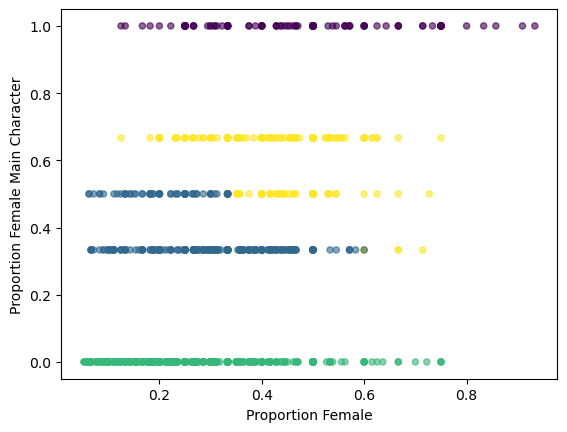

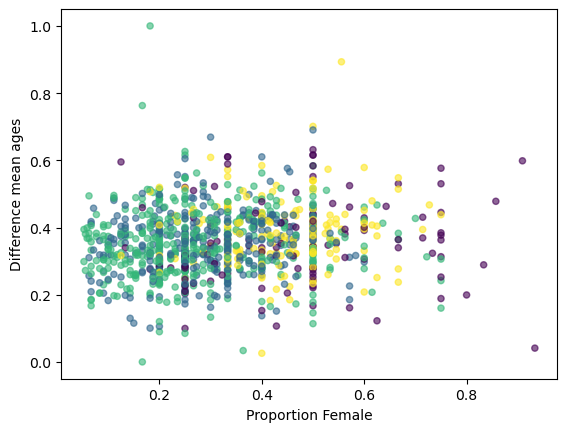

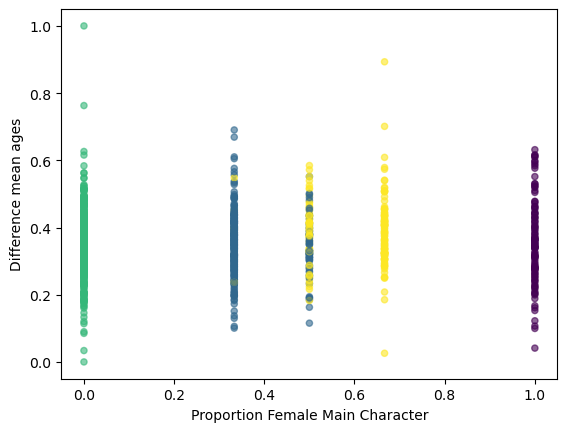

In [31]:
kmean = KMeans(n_clusters=4, random_state=0).fit(data)

plt.scatter(data['proportion_female'], data['proportion_female_main_char'], c=kmean.labels_, alpha=0.6, s=20)
plt.xlabel("Proportion Female")
plt.ylabel("Proportion Female Main Character")
plt.show()

plt.scatter(data['proportion_female'], data['difference_mean_ages'], c=kmean.labels_, alpha=0.6, s=20)
plt.xlabel("Proportion Female")
plt.ylabel("Difference mean ages")
plt.show()

plt.scatter(data['proportion_female_main_char'], data['difference_mean_ages'], c=kmean.labels_, alpha=0.6, s=20)
plt.xlabel("Proportion Female Main Character")
plt.ylabel("Difference mean ages")
plt.show()

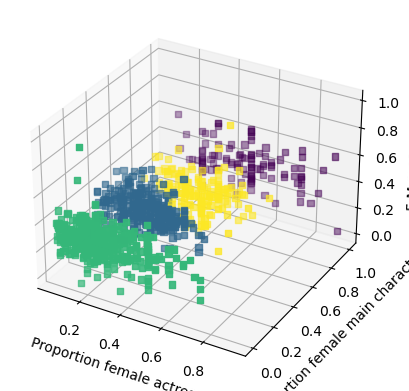

In [33]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = np.array(data['proportion_female'])
y = np.array(data['proportion_female_main_char'])
z = np.array(data['difference_mean_ages'])
ax.set_xlabel('Proportion female actress')
ax.set_ylabel('Proportion female main character')
ax.set_zlabel('F-M mean age')

ax.scatter(x,y,z, marker="s", c=kmean.labels_)

plt.show()

### Clustering with DBScan

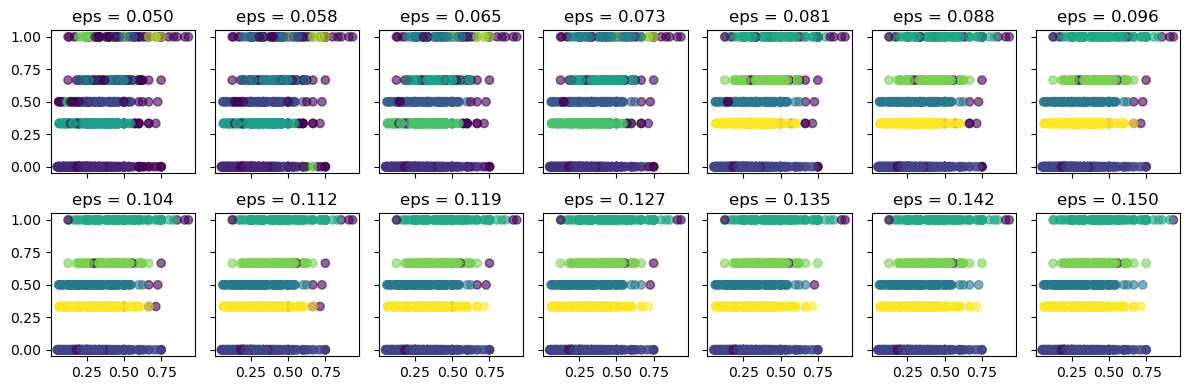

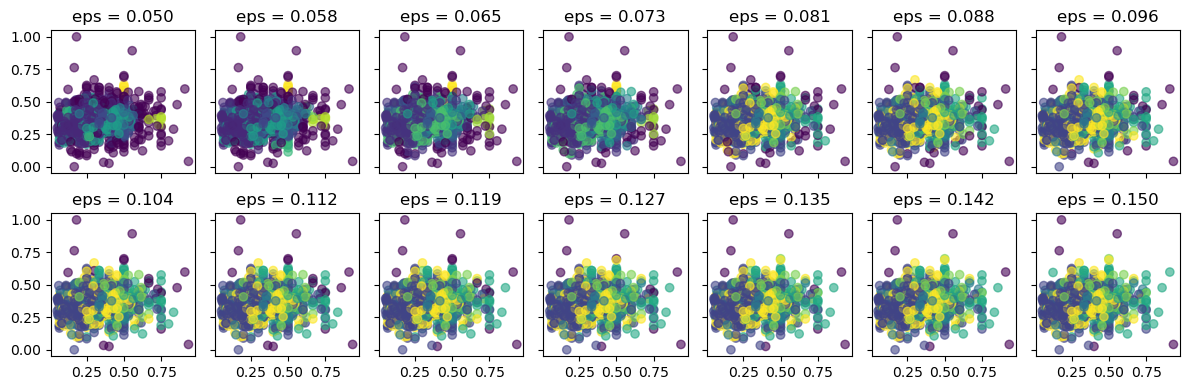

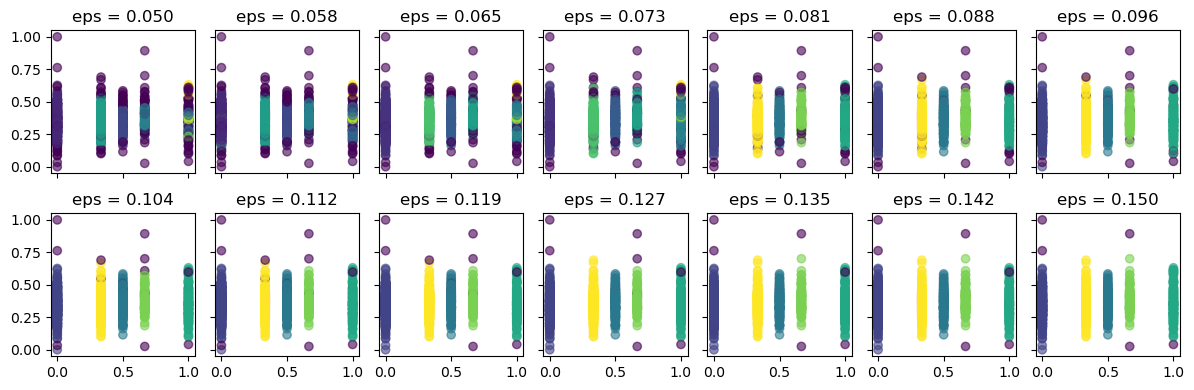

In [24]:
# Create a list of eps
eps_list = np.linspace(0.05, 0.15, 14)

# Compute number of row and columns
COLUMNS = 7
ROWS = math.ceil(len(eps_list)/COLUMNS)

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)


for i in range(0, len(eps_list)):
    eps = eps_list[i]

    current_column = i%COLUMNS
    current_row = i//COLUMNS

    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(data)
    ax.scatter(data['proportion_female'], data['proportion_female_main_char'], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))

plt.tight_layout()

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)

for i in range(0, len(eps_list)):
    eps = eps_list[i]

    current_column = i%COLUMNS
    current_row = i//COLUMNS

    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(data)
    ax.scatter(data['proportion_female'], data['difference_mean_ages'], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))

plt.tight_layout()

fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(12, 4), sharey=True, sharex=True)
for i in range(0, len(eps_list)):
    eps = eps_list[i]

    current_column = i%COLUMNS
    current_row = i//COLUMNS

    ax = axs[current_row, current_column]
    labels = DBSCAN(eps=eps).fit_predict(data)
    ax.scatter(data['proportion_female_main_char'], data['difference_mean_ages'], c=labels, alpha=0.6)
    ax.set_title("eps = {:.3f}".format(eps))

plt.tight_layout()

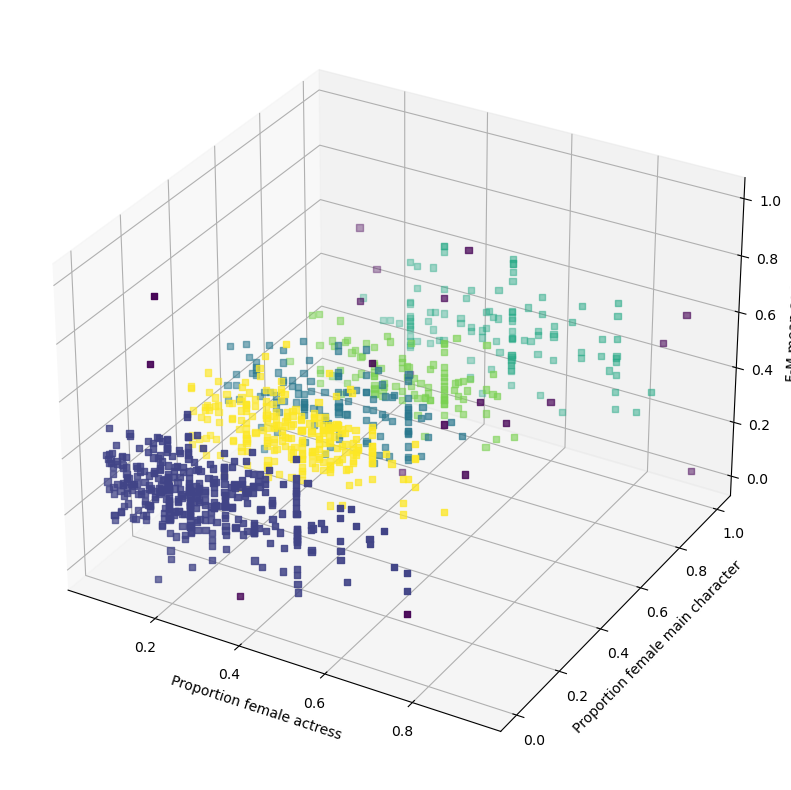

In [25]:
eps = 0.1

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
labels = DBSCAN(eps=eps).fit_predict(data)
x = np.array(data['proportion_female'])
y = np.array(data['proportion_female_main_char'])
z = np.array(data['difference_mean_ages'])
ax.set_xlabel('Proportion female actress')
ax.set_ylabel('Proportion female main character')
ax.set_zlabel('F-M mean age')

ax.scatter(x,y,z, marker="s", c=labels, s=20)

plt.show()